In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
random_state=0

In [2]:
data= pd.read_csv('auto-mpg.csv')

In [3]:
data.head()

,mpg,cylinders,displacement,hp,weight,acc,year,carname
0,18.0,8,307.0,130,3504,12.0,70,"1\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165,3693,11.5,70,"1\t""buick skylark 320"""
2,18.0,8,318.0,150,3436,11.0,70,"1\t""plymouth satellite"""
3,16.0,8,304.0,150,3433,12.0,70,"1\t""amc rebel sst"""
4,17.0,8,302.0,140,3449,10.5,70,"1\t""ford torino"""


In [4]:
# convert a feature to categorical
data['carname'] = data['carname'].astype('category')
data["carname"] = data["carname"].cat.codes

In [5]:
# separate the features and the target variable
X = data.iloc[:, 1:] # select all columns except the first one as features
y = data.iloc[:, 0] # select the first column as the target variable

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.20,random_state=0)

In [7]:
def preprocess_data(X_train, X_test, y_train, kappa):
    # Find columns with extra values
    unique_values = {col: X_train[col].unique() for col in X_train.columns}
    columns_with_extra_values = []

    for col in X_train.columns:
        extra_values = set(X_test[col].unique()) - set(unique_values[col])
        if extra_values:
            print(f"Warning: There are values in column '{col}' of X_test that are not present in X_train.")
            columns_with_extra_values.append(col)

    # Calculate mean for unique values in all columns
    mean_values = {}
    
    for col in X_train.columns:
        unique_values = X_train[col].unique()
        col_mean_values = {}
        
        for value in unique_values:
            indices = X_train[X_train[col] == value].index
            col_mean_values[value] = y_train.iloc[indices].mean()
        
        mean_values[col] = col_mean_values

    # Replace unique values in X_train and X_test with their corresponding means only for columns without extra values
    for col, col_mean_values in mean_values.items():
        if col not in columns_with_extra_values:
            X_train[col] = X_train[col].apply(lambda x: col_mean_values[x])
            X_test[col] = X_test[col].apply(lambda x: col_mean_values[x])

    
    for col in columns_with_extra_values:
        # X_train
        d_train = np.zeros((len(X_train), len(X_train)))
        for i in range(len(X_train)):
            for j in range(len(X_train)):
                d_train[i, j] = np.linalg.norm(X_train.iloc[i] - X_train.iloc[j])

        c_train = np.zeros(len(X_train))
        for i in range(len(X_train)):
            l = 0
            v = 0
            for j in range(len(y_train)):
                l += y_train.iloc[j] / ((1 + d_train[i, j]) ** kappa)
                v += 1 / ((1 + d_train[i, j]) ** kappa)
            c_train[i] = l / v

        X_train[col] = c_train

        # X_test
        d_test = np.zeros((len(X_test), len(X_train)))
        for i in range(len(X_test)):
            for j in range(len(X_train)):
                d_test[i, j] = np.linalg.norm(X_test.iloc[i] - X_train.iloc[j])

        c_test = np.zeros(len(X_test))
        for i in range(len(X_test)):
            l = 0
            v = 0
            for j in range(len(y_train)):
                l += y_train.iloc[j] / ((1 + d_test[i, j]) ** kappa)
                v += 1 / ((1 + d_test[i, j]) ** kappa)
            c_test[i] = l / v

        X_test[col] = c_test

    return X_train, X_test


In [8]:
def preprocess_data(X_train, X_test, y_train, kappa):
    # Find columns with extra values
    unique_values = {col: X_train[col].unique() for col in X_train.columns}
    columns_with_extra_values = []

    for col in X_train.columns:
        extra_values = set(X_test[col].unique()) - set(unique_values[col])
        if extra_values:
            print(f"Warning: There are values in column '{col}' of X_test that are not present in X_train.")
            columns_with_extra_values.append(col)

    # Calculate mean for unique values in all columns
    mean_values = {}
    
    for col in X_train.columns:
        unique_values = X_train[col].unique()
        col_mean_values = {}
        
        for value in unique_values:
            indices = X_train[X_train[col] == value].index
            col_mean_values[value] = y_train.iloc[indices].mean()
        
        mean_values[col] = col_mean_values

    # Replace unique values in X_train and X_test with their corresponding means only for columns without extra values
    for col, col_mean_values in mean_values.items():
        if col not in columns_with_extra_values:
            X_train[col] = X_train[col].apply(lambda x: col_mean_values[x])
            X_test[col] = X_test[col].apply(lambda x: col_mean_values[x])

    # Apply proportional regularization to columns with extra values for all values
    for col in columns_with_extra_values:
        # Calculate proportional regularization for X_train
        d_train = np.zeros((len(X_train), len(X_train)))
        for i in range(len(X_train)):
            for j in range(len(X_train)):
                d_train[i, j] = np.linalg.norm(X_train.iloc[i] - X_train.iloc[j])

        c_train = np.zeros(len(X_train))
        for i in range(len(X_train)):
            l = 0
            v = 0
            for j in range(len(y_train)):
                l += y_train.iloc[j] / ((1 + d_train[i, j]) ** kappa)
                v += 1 / ((1 + d_train[i, j]) ** kappa)
            c_train[i] = l / v

        X_train[col] = c_train

        # Calculate proportional regularization for X_test
        d_test = np.zeros((len(X_test), len(X_train)))
        for i in range(len(X_test)):
            for j in range(len(X_train)):
                d_test[i, j] = np.linalg.norm(X_test.iloc[i] - X_train.iloc[j])

        c_test = np.zeros(len(X_test))
        for i in range(len(X_test)):
            l = 0
            v = 0
            for j in range(len(y_train)):
                l += y_train.iloc[j] / ((1 + d_test[i, j]) ** kappa)
                v += 1 / ((1 + d_test[i, j]) ** kappa)
            c_test[i] = l / v

        X_test[col] = c_test

    return X_train, X_test


In [9]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

kappa = 5
X_train_preprocessed, X_test_preprocessed = preprocess_data(X_train, X_test, y_train, kappa)

<ipython-input-8-28cafbe14cce>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].apply(lambda x: col_mean_values[x])
<ipython-input-8-28cafbe14cce>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].apply(lambda x: col_mean_values[x])
<ipython-input-8-28cafbe14cce>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [10]:
X_train= X_train_preprocessed
X_test= X_test_preprocessed

In [11]:
print(X_test)
print(X_train)

     cylinders  displacement         hp     weight        acc       year  \
144  29.336709     29.890151  29.126557  23.595221  24.515564  23.500000   
280  29.336709     24.059739  24.483927  23.575482  22.747963  25.700000   
68   15.012658     13.904750  13.750719  23.548593  15.970462  18.900000   
372  29.336709     33.294271  34.617573  23.627213  25.507835  32.346154   
328  29.336709     34.360549  33.884367  23.672495  29.328457  32.694444   
..         ...           ...        ...        ...        ...        ...   
100  19.775362     24.118416  25.142239  23.585517  19.512915  16.757576   
64   15.012658     15.123386  14.942363  23.549963  15.591830  18.900000   
55   29.336709     33.710739  33.646228  23.635976  25.255037  20.454545   
260  15.012658     18.730819  18.621846  23.554175  17.911432  23.562069   
214  29.336709     35.705683  36.422434  23.675756  29.781446  23.659091   

       carname  
144  28.298290  
280  26.806256  
68   25.003295  
372  26.085221  
32

In [12]:
def prop_reg(X_test,X_train,y_train,y_test,kappa):
    d = np.zeros((len(X_test),len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            d[i,j] = np.linalg.norm(X_test[i]-X_train[j])
    c=np.zeros(len(y_test))
    for i in range(len(y_test)):
        l=0
        v=0
        for j in range(len(y_train)):
            
            l+=y_train[j]/((1+d[i,j])**kappa)
            v+=1/((1+d[i,j])**kappa)
        
        c[i]=l/v
    return(c)

kappa = 1.600, avg MSE = 20.463
kappa = 1.700, avg MSE = 20.103
kappa = 1.800, avg MSE = 19.842
kappa = 1.900, avg MSE = 19.661
kappa = 2.000, avg MSE = 19.544
kappa = 2.100, avg MSE = 19.478
kappa = 2.200, avg MSE = 19.453
kappa = 2.300, avg MSE = 19.460
kappa = 2.400, avg MSE = 19.493
kappa = 2.500, avg MSE = 19.547
kappa = 2.600, avg MSE = 19.617
kappa = 2.700, avg MSE = 19.698
kappa = 2.800, avg MSE = 19.789
kappa = 2.900, avg MSE = 19.886
kappa = 3.000, avg MSE = 19.988


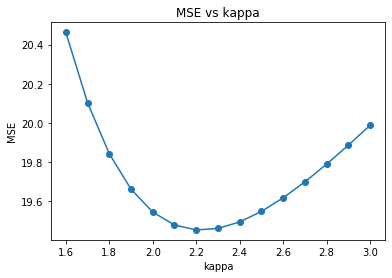

In [13]:
kf = KFold(n_splits=10)
kappa_values = np.array([1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0])
mse_values = []

for kappa in kappa_values:
    mse = 0.0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        y_pred = prop_reg(X_test, X_train, y_train, y_test, kappa)
        mse += mean_squared_error(y_test, y_pred)
    mse /= kf.get_n_splits(X)
    mse_values.append(mse)
    print(f"kappa = {kappa:.3f}, avg MSE = {mse:.3f}")

# plot the MSE vs kappa curve
plt.plot(kappa_values, mse_values, '-o')
plt.xlabel('kappa')
plt.ylabel('MSE')
plt.title('MSE vs kappa')
plt.show()

In [14]:
# find the index of the minimum MSE value
min_index = np.argmin(mse_values)

# print the minimum MSE value and the corresponding kappa value
print(f"Minimum MSE: {mse_values[min_index]:.3f}, Kappa value: {kappa_values[min_index]}")


Minimum MSE: 19.453, Kappa value: 2.2
